In [2]:
!pip install tflearn

In [3]:
!ls .forever -l

total 16
-rw-r--r-- 1 root root  439 Feb  1 03:21 checkpoint
-rw-r--r-- 1 root root  278 Feb  1 02:32 config.json
drwxr-xr-x 2 root root 4096 Feb  1 02:32 pids
drwxr-xr-x 2 root root 4096 Feb  1 02:32 sock


In [0]:
from __future__ import division, print_function, absolute_import

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation


In [5]:
!pip install pydrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [7]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))


title: test_data.pkl, id: 1KCSmqhZKEKrnIV2qIOLU7z_nKueCKg9z
title: holdout_data.pkl, id: 1p9Z7rusfr5t17I6cX7s7XkZQKGEbNTbb
title: data.pkl, id: 1UYgn-xtVRLS6kybgWoPgy5LiQVIRhL75


In [0]:
import pickle
PIK = "1UYgn-xtVRLS6kybgWoPgy5LiQVIRhL75"
TESTPIK = "1KCSmqhZKEKrnIV2qIOLU7z_nKueCKg9z"
ORITESTPIK = "1p9Z7rusfr5t17I6cX7s7XkZQKGEbNTbb"


In [0]:
X = []
Y = []
X_test = []
Y_test = []
Ori_X_test = []
Ori_Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}


In [0]:
dataFile = drive.CreateFile({'id': PIK}).GetContentFile('train.pkl')

In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile('test.pkl')

In [0]:
validateFile = drive.CreateFile({'id': ORITESTPIK}).GetContentFile('validate.pkl')

In [13]:

X_type = 'float64'

with open('train.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X.append(record[0].astype(X_type))
            Y.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Train Data Size :" , len(X))


processing done!
Train Data Size : 10086


In [14]:
with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 1352


In [15]:
with open('validate.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            Ori_X_test.append(record[0].astype(X_type))
            Ori_Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Original Test Data Size :" , len(Ori_X_test))

processing done!
Original Test Data Size : 80


In [16]:
#convert to categorical variables
Y = to_categorical(Y, 9)
Y_test = to_categorical(Y_test, 9)
Ori_Y_test = to_categorical(Ori_Y_test, 9)

from __future__ import division, print_function, absolute_import

import tflearn

# Residual blocks
# 32 layers: n=5, 56 layers: n=9, 110 layers: n=18
n = 5

# Real-time data preprocessing
img_prep = tflearn.ImagePreprocessing()
img_prep.add_featurewise_zero_center(per_channel=True)

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_crop([64, 64], padding=4)

# Building Residual Network
net = tflearn.input_data(shape=[None, 64, 64, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)
net = tflearn.conv_2d(net, 16, 3, regularizer='L2', weight_decay=0.0001)
net = tflearn.resnext_block(net, n, 16, 32)
net = tflearn.resnext_block(net, 1, 32, 32, downsample=True)
net = tflearn.resnext_block(net, n-1, 32, 32)
net = tflearn.resnext_block(net, 1, 64, 32, downsample=True)
net = tflearn.resnext_block(net, n-1, 64, 32)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)
# Regression
net = tflearn.fully_connected(net, 9, activation='softmax')
opt = tflearn.Momentum(0.1, lr_decay=0.1, decay_step=32000, staircase=True)
net = tflearn.regression(net, optimizer=opt,
                         loss='categorical_crossentropy')


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [0]:
# Training

start_time = time.time()

model = tflearn.DNN(net, checkpoint_path='.forever/model_resnext_cifar10',
                    max_checkpoints=10, tensorboard_verbose=0,
                    clip_gradients=0.)

In [18]:


model.fit(X, Y, n_epoch=50, validation_set=(X_test, Y_test),
          snapshot_epoch=20, snapshot_step=500,
          show_metric=True, batch_size=64, shuffle=True,
          run_id='resnext_cifar10')


Training Step: 7899  | total loss: 0.20216 | time: 194.917s
| Momentum | epoch: 050 | loss: 0.20216 - acc: 0.9328 -- iter: 10048/10086
Training Step: 7900  | total loss: 0.20326 | time: 199.184s
| Momentum | epoch: 050 | loss: 0.20326 - acc: 0.9317 | val_loss: 2.23574 - val_acc: 0.4667 -- iter: 10086/10086
--


In [19]:
 model.save("tflearn-v0.70.tfl")
 print("Network trained and saved as tflearn-v0.70.tfl. time taken: " , time.time() - start_time)



Network trained and saved as tflearn-v0.70.tfl. time taken:  10189.454042196274


In [20]:
import os
os.listdir('/content/')

['datalab',
 'validate.pkl',
 '.ipython',
 '.config',
 '.forever',
 'tflearn-v0.70.tfl.data-00000-of-00001',
 'test.pkl',
 '.rnd',
 '.nv',
 'tflearn-v0.70.tfl.index',
 'train.pkl',
 '.cache',
 'tflearn-v0.70.tfl.meta',
 '.local',
 'checkpoint',
 '.keras']

In [0]:

label_pairs_reverse ={
    1:'adho_mukha_svanasana',
    2:'bharadvajasana',
    3:'pasasana',
    4:'salamba_sarvangasana',
    5:'salamba_sirsasana',
    6:'virabhadrasana_I',
    7:'virabhadrasana_II',
    8:'virabhadrasana_III'
}

In [22]:

holdout_X_test = []
holdout_Y_test = []
with open('validate.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            holdout_X_test.append(record[0].astype(X_type))
            holdout_Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
holdout_images_and_labels = list(zip(holdout_X_test, holdout_Y_test))
correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []

for index, (image, label) in enumerate(holdout_images_and_labels):
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    # label = label.argmax(axis=0)
    # print("Pred: {pred} Actual:{label}".format(pred=pred, label=label) )
    #print(int(pred))
    #print(int(label))
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
    if int(pred) == int(label) :
        correct_count=correct_count+1
        correct_indices = np.append(correct_indices,int(index))
    else :
        wrong_count=wrong_count+1
        wrong_indices = np.append(wrong_indices,int(index))

accuracy=correct_count/(correct_count+wrong_count)
print(accuracy)
print(correct_count)
print(wrong_count)


processing done!
0.45
36
44


In [0]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[5 0 0 0 0 1 4 0]
 [0 3 2 0 0 4 1 0]
 [0 0 6 1 0 2 1 0]
 [0 0 0 8 0 1 1 0]
 [0 0 0 7 0 3 0 0]
 [0 0 0 1 0 5 4 0]
 [0 0 0 1 0 3 5 1]
 [0 0 1 1 0 2 2 4]]
Confusion matrix, without normalization
[[5 0 0 0 0 1 4 0]
 [0 3 2 0 0 4 1 0]
 [0 0 6 1 0 2 1 0]
 [0 0 0 8 0 1 1 0]
 [0 0 0 7 0 3 0 0]
 [0 0 0 1 0 5 4 0]
 [0 0 0 1 0 3 5 1]
 [0 0 1 1 0 2 2 4]]
Normalized confusion matrix
[[0.5 0.  0.  0.  0.  0.1 0.4 0. ]
 [0.  0.3 0.2 0.  0.  0.4 0.1 0. ]
 [0.  0.  0.6 0.1 0.  0.2 0.1 0. ]
 [0.  0.  0.  0.8 0.  0.1 0.1 0. ]
 [0.  0.  0.  0.7 0.  0.3 0.  0. ]
 [0.  0.  0.  0.1 0.  0.5 0.4 0. ]
 [0.  0.  0.  0.1 0.  0.3 0.5 0.1]
 [0.  0.  0.1 0.1 0.  0.2 0.2 0.4]]


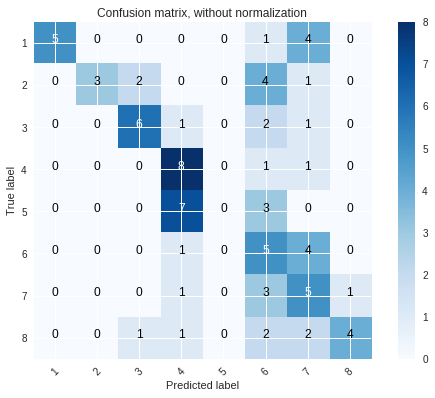

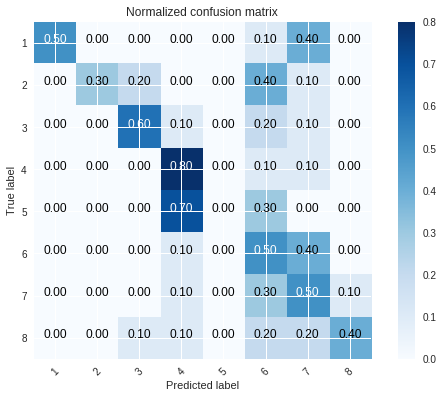

In [25]:
np.set_printoptions(threshold=np.nan)
class_names=['1','2','3','4','5','6','7','8']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()